# Credit Card Default - Kaggle
The intention of this mini project on a classification problem is to explore the data, engineer new features, do the preprocessing, perform feature selection, build the optimized model and score it on the test data under 8 hours. I will record my lessons learned and what I could have done better for future projects at the end of the notebook.

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from pandas_profiling import ProfileReport

from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier

from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor, VotingClassifier, StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import (
    cross_validate,
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import classification_report, recall_score, f1_score, precision_score, roc_auc_score

import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable("data_server")

import seaborn as sns
%matplotlib inline

<br><br>

## 1. Data - Prediction problem
<hr>


This is a classification problem of predicting whether a credit card client will default or not. For this problem, I will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. 


I will spend some time understanding the problem and what each feature means and will write a few sentences on my initial thoughts on the problem and the dataset. 

There are 25 variables:

ID: ID of each client  
LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit  
SEX: Gender (1=male, 2=female)  
EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)  
MARRIAGE: Marital status (1=married, 2=single, 3=others)  
AGE: Age in years  
PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)  
PAY_2: Repayment status in August, 2005 (scale same as above)  
PAY_3: Repayment status in July, 2005 (scale same as above)  
PAY_4: Repayment status in June, 2005 (scale same as above)  
PAY_5: Repayment status in May, 2005 (scale same as above)  
PAY_6: Repayment status in April, 2005 (scale same as above)  
BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)  
BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)  
BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)  
BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)  
BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)  
BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)  
PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)  
PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)  
PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)  
PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)  
PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)  
PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)  


default.payment.next.month: Default payment (1=yes, 0=no)


In [6]:
credit = pd.read_csv("../downloads/UCI_Credit_Card.csv")

In [8]:
credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [10]:
credit.tail()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
29995,29996,220000.0,1,3,1,39,0,0,0,0,0,0,188948.0,192815.0,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,0,0,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,0,0,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,0,-1,-1645.0,78379.0,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1
29999,30000,50000.0,1,2,1,46,0,0,0,0,0,0,47929.0,48905.0,49764.0,36535.0,32428.0,15313.0,2078.0,1800.0,1430.0,1000.0,1000.0,1000.0,1


In [11]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

I will be dropping the whole row if a review_per_month (our target) does not exist. I will be losing less than 50 examples which is about 0.1% of the dataset.

In [3]:
airbnb = airbnb[airbnb["reviews_per_month"].notna()]

In [4]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38843 entries, 0 to 48852
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              38843 non-null  int64  
 1   name                            38837 non-null  object 
 2   host_id                         38843 non-null  int64  
 3   host_name                       38827 non-null  object 
 4   neighbourhood_group             38843 non-null  object 
 5   neighbourhood                   38843 non-null  object 
 6   latitude                        38843 non-null  float64
 7   longitude                       38843 non-null  float64
 8   room_type                       38843 non-null  object 
 9   price                           38843 non-null  int64  
 10  minimum_nights                  38843 non-null  int64  
 11  number_of_reviews               38843 non-null  int64  
 12  last_review                     

In [5]:
airbnb[airbnb["name"].isna()].head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
3703,2232600,NaN,11395220,Anna,Manhattan,East Village,40.73215,-73.98821,Entire home/apt,200,1,28,2015-06-08,0.45,1,341
5775,4209595,NaN,20700823,Jesse,Manhattan,Greenwich Village,40.73473,-73.99244,Entire home/apt,225,1,1,2015-01-01,0.02,1,0
5975,4370230,NaN,22686810,Michaël,Manhattan,Nolita,40.72046,-73.99550,Entire home/apt,215,7,5,2016-01-02,0.09,1,0


In [6]:
airbnb[airbnb["host_name"].isna()].head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
360,100184,Bienvenue,526653,NaN,Queens,Queens Village,40.72413,-73.76133,Private room,50,1,43,2019-07-08,0.45,1,88
2700,1449546,Cozy Studio in Flatbush,7779204,NaN,Brooklyn,Flatbush,40.64965,-73.96154,Entire home/apt,100,30,49,2017-01-02,0.69,1,342
5745,4183989,SPRING in the City!! Zen-Style Tranquil Bedroom,919218,NaN,Manhattan,Harlem,40.80606,-73.95061,Private room,86,3,34,2019-05-23,1.00,1,359


There are some NA's in the name and host name columns. I will replace them with "None", because later I want to use OneHotEncoder and CountVectorizer on those columns. Since the rows do not agree on the the missing values for name and host_name, there is no point of dropping these rows.

In [7]:
airbnb = airbnb.fillna(value="None")

I know I am not supposed to be looking at the test data at this stage, but in my analysis in next steps I realized there appears to be an outlier in the dataset which I will be removing here.

In [8]:
airbnb[airbnb["reviews_per_month"] == 58.5]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
42075,32678719,Enjoy great views of the City in our Deluxe Room!,244361589,Row NYC,Manhattan,Theater District,40.75918,-73.98801,Private room,100,1,156,2019-07-07,58.5,9,299


In [9]:
airbnb = airbnb[airbnb["reviews_per_month"] != 58.5]

I will be changing the last_review feature to date-time to extract features from it later.

In [10]:
airbnb['last_review'] = airbnb['last_review'].apply(lambda x: pd.Timestamp(x))

<br><br>

## 2. Data splitting 
<hr>

1. Split the data into train and test portions.

> Make decision on the `test_size` based on the capacity of your laptop. Don't forget to use a random state.  

In [11]:
X_train, X_test, y_train, y_test = train_test_split(airbnb.drop("reviews_per_month", axis=1), airbnb["reviews_per_month"], test_size=0.7, random_state=2021)

<br><br>

## 3. EDA 
<hr>


1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

In [12]:
airbnb.describe(include="all")

C:\Users\artan\AppData\Local\Temp/ipykernel_15696/3490539498.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  airbnb.describe(include="all")


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
count,3.884200e+04,38842,3.884200e+04,38842,38842,38842,38842.000000,38842.000000,38842,38842.000000,38842.000000,38842.000000,38842,38842.000000,38842.000000,38842.000000
unique,NaN,38269,NaN,9887,5,218,NaN,NaN,3,NaN,NaN,NaN,1764,NaN,NaN,NaN
top,NaN,Home away from home,NaN,Michael,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,2019-06-23 00:00:00,NaN,NaN,NaN
freq,NaN,12,NaN,335,16631,3163,NaN,NaN,20332,NaN,NaN,NaN,1413,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-03-28 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-08 00:00:00,NaN,NaN,NaN
mean,1.809609e+07,NaN,6.423451e+07,NaN,NaN,NaN,40.728133,-73.951147,NaN,142.319036,5.868184,29.294295,NaN,1.371751,5.164358,114.878147
std,1.069358e+07,NaN,7.588395e+07,NaN,NaN,NaN,0.054991,0.046695,NaN,196.948042,17.384990,48.182705,NaN,1.655275,26.295997,129.541935
min,2.539000e+03,NaN,2.438000e+03,NaN,NaN,NaN,40.506410,-74.244420,NaN,0.000000,1.000000,1.000000,NaN,0.010000,1.000000,0.000000
25%,8.720006e+06,NaN,7.033777e+06,NaN,NaN,NaN,40.688640,-73.982470,NaN,69.000000,1.000000,3.000000,NaN,0.190000,1.000000,0.000000


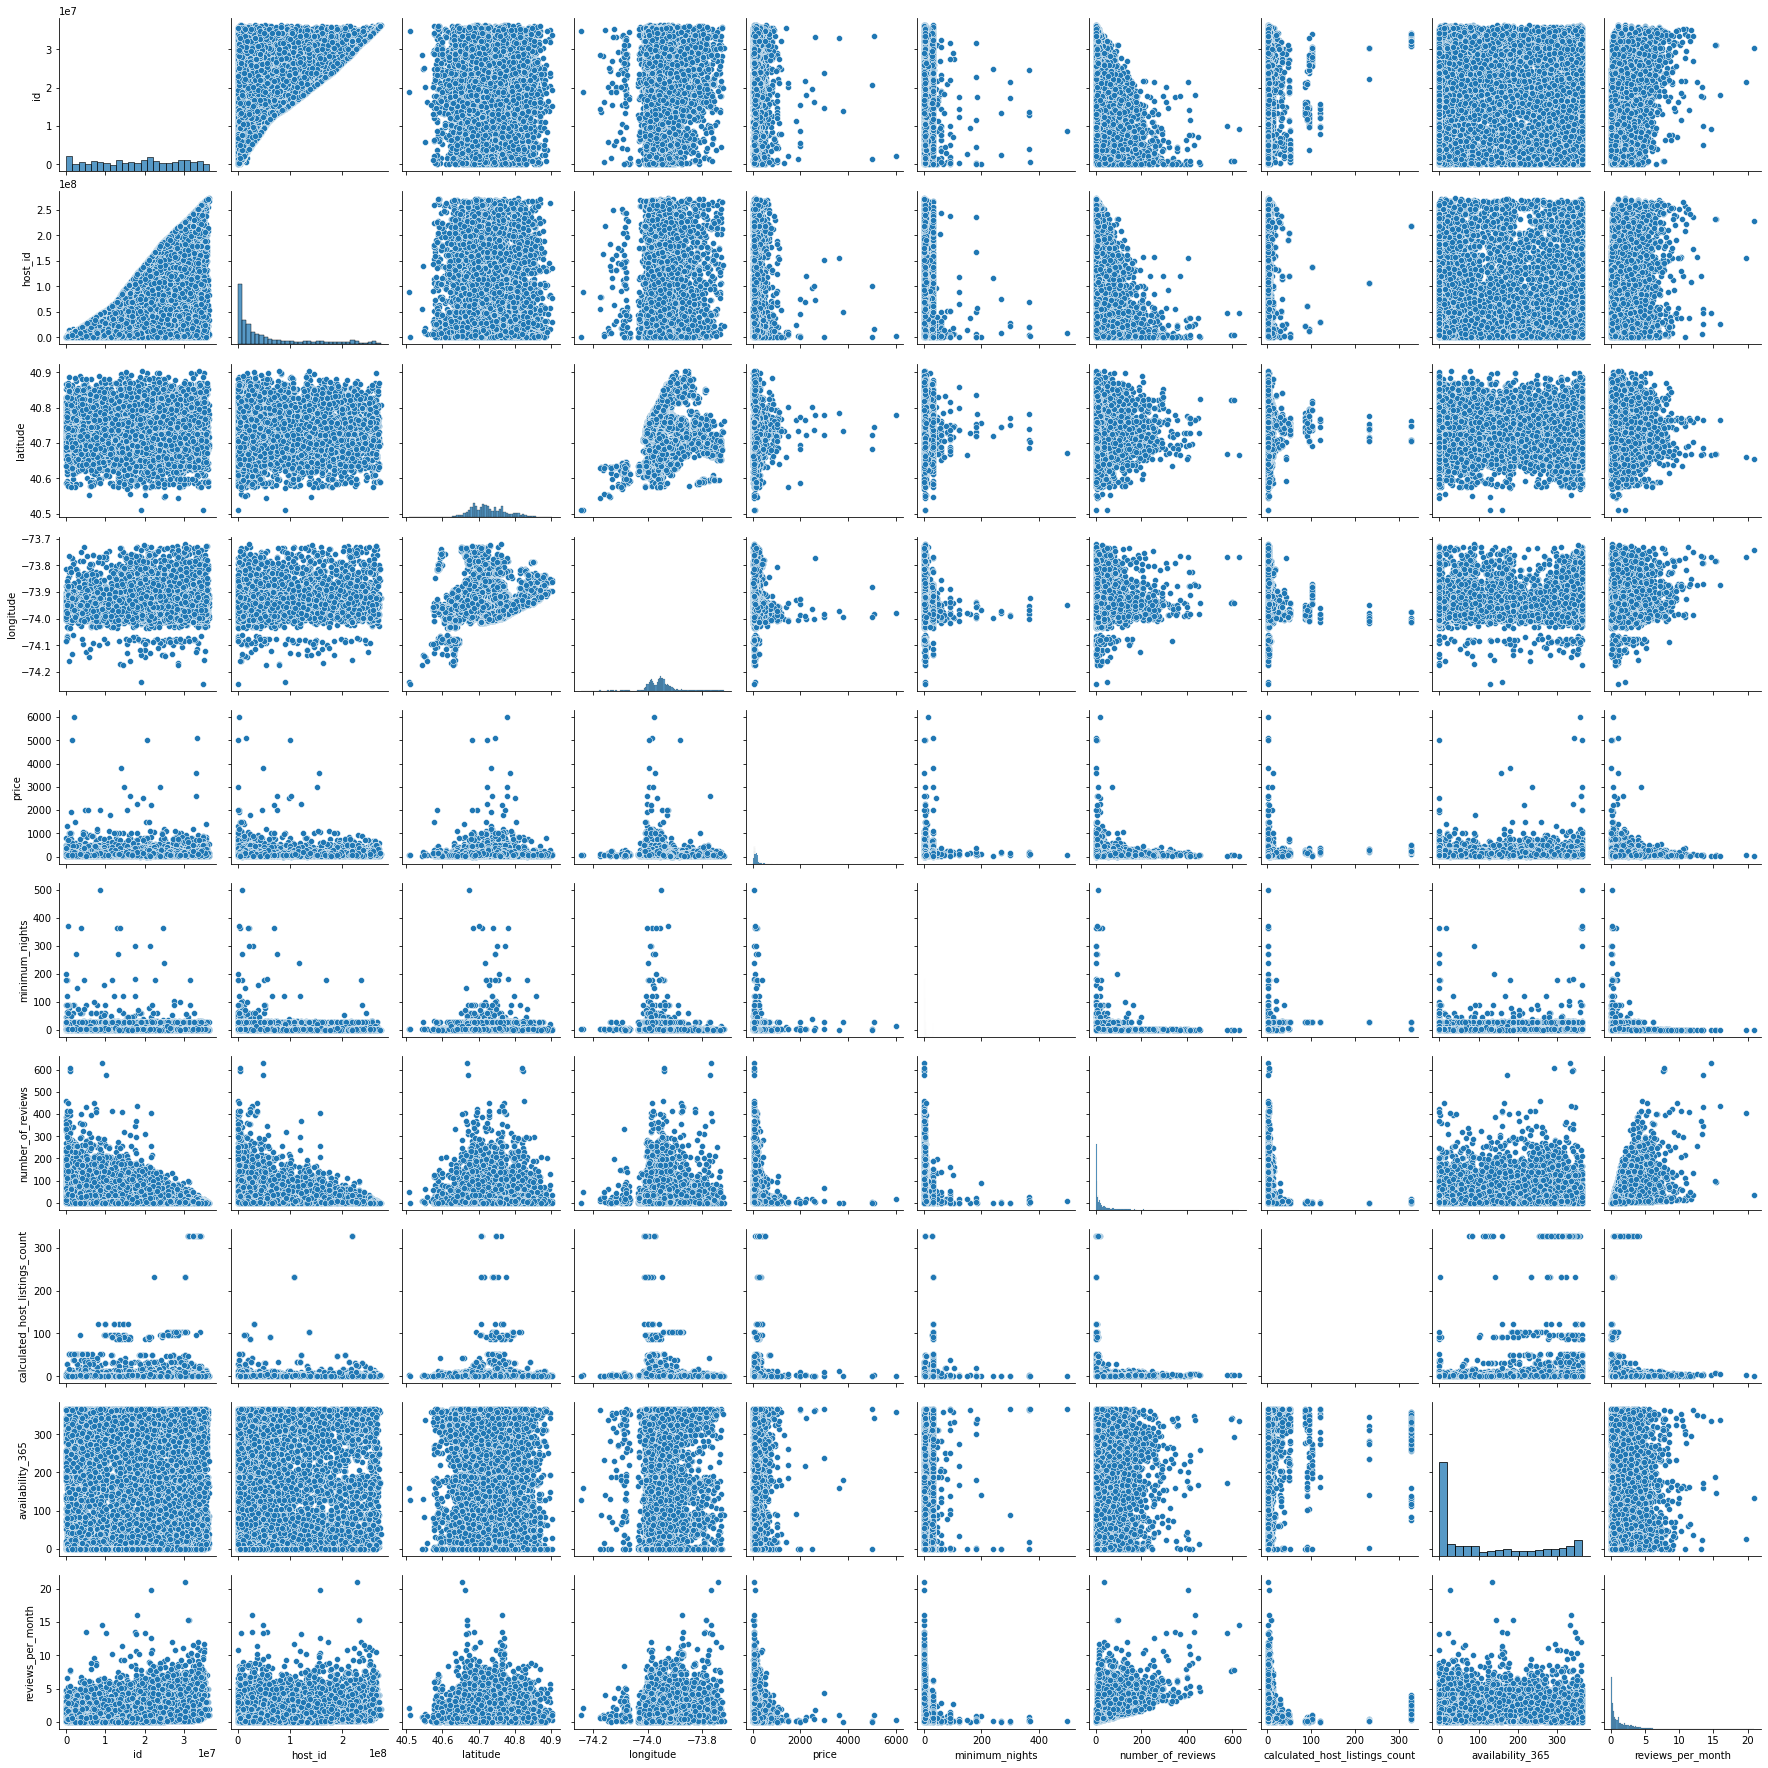

In [13]:
sns.pairplot(pd.concat([X_train, y_train], axis=1))

From the above we can see that the variation of reviews_per_month increases as longitude increases. Also, there is a correlation between number_of_reviews and reviews_per_month which makes total sense.

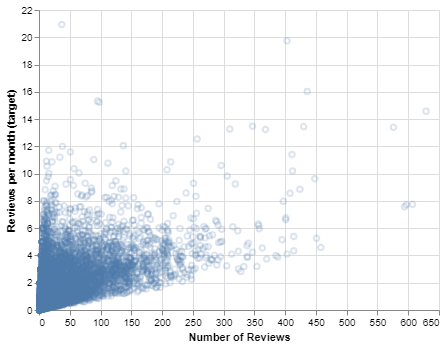

In [14]:
alt.Chart(pd.concat([X_train, y_train], axis=1)).mark_point(opacity=0.2).encode(
    x=alt.X("number_of_reviews", title="Number of Reviews"),
    y=alt.Y("reviews_per_month", title="Reviews per month (target)")
)

The target seems to be very right-skewed. We might have removed the outliers (e.g. values > 10) for better prediction.

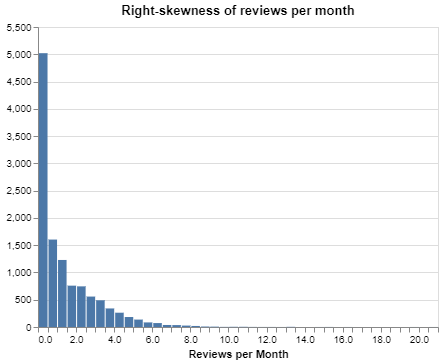

In [15]:
alt.Chart(pd.DataFrame(y_train), title="Right-skewness of reviews per month").mark_bar().encode(
    x=alt.X("reviews_per_month", bin=alt.Bin(maxbins=50), title="Reviews per Month"),
    y=alt.Y("count()", title="")
)

_The most important summary stats belong to `minimum_nights` where minimum value is 1, 1 is also the 25% percentile, 2 is median, and 4 is the 75% percentile._

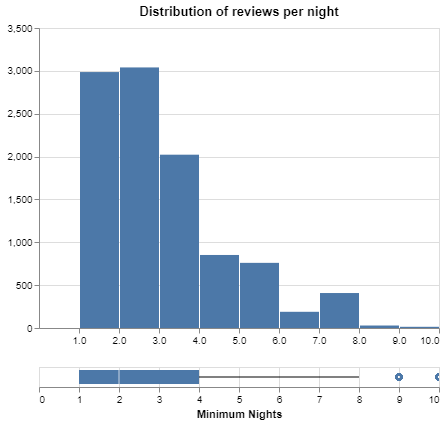

In [16]:
alt.Chart(X_train, title="Distribution of reviews per night").mark_bar(clip=True).encode(
    x=alt.X("minimum_nights", bin=alt.Bin(maxbins=700), scale=alt.Scale(domain=(0,10)), title=""),
    y=alt.Y("count()", title="")
) & alt.Chart(X_train).mark_boxplot(clip=True).encode(
    x=alt.X("minimum_nights", scale=alt.Scale(domain=(0,10)), title="Minimum Nights"),
    
)

_3. Except for some outliers the rest of the data seems to be in a specific range. The skewedness of data will cause the regression line to not best represent the underlying weights, and it might be necessary to use L1 (absolute mean error) as the cost function instead of L2 (root mean square error) to minimize the effect of penalizing squared differences. Some columns including id, and last_review after month and year are extracted from it, could be dropped. OneHotEncoding could be applied on the name feature to see if having a common name would increase the rate of monthly reviews._  
_4. I will be picking RMSE as my metric for this analysis. Since our target is very right-skewed using a metric like mape does not make much sense._

In [17]:
scoring = 'neg_root_mean_squared_error'

<br><br>

## 4. Feature engineering 
<hr>


1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

_I am creating two extra columns by extracting the month and year from the timestamp object `last_review` that I had previously created. I am also interested to if the weekday of the review would have any effect on my target._

In [18]:
X_train['year'] = X_train["last_review"].dt.year
X_train['month'] = X_train["last_review"].dt.month
X_train['weekday'] = X_train["last_review"].dt.day_name()

<br><br>

## 5. Preprocessing and transformations
<hr>


1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [19]:
# dropping neighborhood_group as neighborhood rolls up to it
# dropping latitude and longitude as neighborhood already contains this info
drop = [
    "id",
    "host_id",
    "neighbourhood_group",
    "latitude",
    "longitude",
    "last_review",
]  # host_id might be useful but as a categorical feature. Dropping due to large count
text1 = "name"
text2 = "host_name"  # Countvectorizer due to having multiple hosts - picking the top 100 names
categorical = ["neighbourhood", "room_type", "year", "month", "weekday"]
numeric = [
    "price",
    "minimum_nights",
    "number_of_reviews",
    "calculated_host_listings_count",
    "availability_365",
]

In [20]:
preprocessor = make_column_transformer(
    ("drop", drop),
    (CountVectorizer(stop_words="english", max_features=100), text1),
    (CountVectorizer(stop_words="english", max_features=100), text2),
    (OneHotEncoder(handle_unknown="ignore"), categorical),
    (StandardScaler(),numeric)
)

<br><br>

## 6. Baseline model 
<hr>

1. Try `scikit-learn`'s baseline model and report results.

In [21]:
# This function has been acquired from lecture notes
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [22]:
results = dict()

dummy_pipe = make_pipeline(preprocessor, DummyRegressor())
results["Dummy Regressor"] = mean_std_cross_val_scores(dummy_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(results)

,Dummy Regressor
fit_time,0.171 (+/- 0.010)
score_time,0.041 (+/- 0.013)
test_score,-1.666 (+/- 0.072)
train_score,-1.666 (+/- 0.018)


<br><br>

## 7. Linear models 
<hr>


1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the regularization hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

In [23]:
ridge_pipe = make_pipeline(preprocessor, Ridge(random_state=2021))
results["Ridge"] = mean_std_cross_val_scores(ridge_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(results)

,Dummy Regressor,Ridge
fit_time,0.171 (+/- 0.010),0.209 (+/- 0.011)
score_time,0.041 (+/- 0.013),0.051 (+/- 0.017)
test_score,-1.666 (+/- 0.072),-1.132 (+/- 0.033)
train_score,-1.666 (+/- 0.018),-1.081 (+/- 0.008)


In [24]:
ridge_params = {
    "ridge__alpha": list(np.logspace(-3,3,7))
}
hyper_ridge = GridSearchCV(ridge_pipe, param_grid=ridge_params, scoring=scoring, cv=5, return_train_score=True)

In [25]:
hyper_ridge.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('drop',
                                                                         'drop',
                                                                         ['id',
                                                                          'host_id',
                                                                          'neighbourhood_group',
                                                                          'latitude',
                                                                          'longitude',
                                                                          'last_review']),
                                                                        ('countvectorizer-1',
                                                                         CountVectorizer(max_features=100,
                               

In [26]:
hyper_ridge.best_params_

{'ridge__alpha': 10.0}

In [27]:
hyper_ridge.best_score_

-1.1228740222455305

In [28]:
tuned_ridge = make_pipeline(preprocessor, Ridge(random_state=2021, alpha = hyper_ridge.best_params_['ridge__alpha']))
results["Tuned Ridge"] = mean_std_cross_val_scores(tuned_ridge, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(results)

,Dummy Regressor,Ridge,Tuned Ridge
fit_time,0.171 (+/- 0.010),0.209 (+/- 0.011),0.184 (+/- 0.007)
score_time,0.041 (+/- 0.013),0.051 (+/- 0.017),0.043 (+/- 0.002)
test_score,-1.666 (+/- 0.072),-1.132 (+/- 0.033),-1.123 (+/- 0.036)
train_score,-1.666 (+/- 0.018),-1.081 (+/- 0.008),-1.087 (+/- 0.009)


_According to the above we can see that the crossvalidation score has a slight improvement with the regularization tuning (from -1.174 to -1.118). Train score has gone down which shows a case of moving away from overfitting (the gap between crossvalidation and train scores have gone down)._

<br><br>

## 8. Different models 
<hr>

1. Try at least 3 other models aside from a linear model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

In [29]:
models = {
    "SVR": make_pipeline(preprocessor, SVR()),
    "Random Forest": make_pipeline(
        preprocessor, RandomForestRegressor(random_state=2021)
    ),
    "LGBM Regressor": make_pipeline(
        preprocessor,
        LGBMRegressor(
            random_state=2021,
            verbose=0,
            force_col_wise=True,
        ),
    ),
}

for name, model in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, cv=5, scoring=scoring
    )

pd.DataFrame(results)

,Dummy Regressor,Ridge,Tuned Ridge,SVR,Random Forest,LGBM Regressor
fit_time,0.171 (+/- 0.010),0.209 (+/- 0.011),0.184 (+/- 0.007),7.625 (+/- 0.294),59.708 (+/- 2.582),0.448 (+/- 0.059)
score_time,0.041 (+/- 0.013),0.051 (+/- 0.017),0.043 (+/- 0.002),1.424 (+/- 0.101),0.100 (+/- 0.009),0.125 (+/- 0.010)
test_score,-1.666 (+/- 0.072),-1.132 (+/- 0.033),-1.123 (+/- 0.036),-1.102 (+/- 0.056),-1.002 (+/- 0.058),-0.987 (+/- 0.048)
train_score,-1.666 (+/- 0.018),-1.081 (+/- 0.008),-1.087 (+/- 0.009),-0.976 (+/- 0.013),-0.373 (+/- 0.008),-0.770 (+/- 0.007)


_2. I have been able to beat linear model using all three new models. In terms of fit time and performance LGBM Regressor seems to be the best of the three added models and I will choose it for further tuning. SVR and Random Forest have very long fit times, and when it comes to scoring time, SVR is the the worst of all as expected. Although none of the three added models come close to the score time for Ridge, it would be rational to use any of these 3 new models because of the large improvement on the RMSE for crossvalidation. There are signs of overfitting for Random forest as the train score has got close to zero and its gap with CV score has increased tremendously. This is mainly due to not having max_depth for decision trees which could potentially be optimized through hyperparameter optimization (I am not doing this because it is resource intensive on my computer)._

<br><br>

## (Optional) 9. Feature selection 
<hr>


Make some attempts to select relevant features. You may try `RFECV`, forward selection or L1 regularization for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

In [30]:
rfe_pipe = make_pipeline(
    preprocessor,
    RFECV(Ridge(), cv=5),
    LGBMRegressor(
        random_state=2021,
        verbose=0,
        force_col_wise=True,
    ),
)

In [31]:
# results["RFE + LGBM"] = mean_std_cross_val_scores(rfe_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
# pd.DataFrame(results)

_Note: This took a long time to run, and I won't be running it for the final submission. Overall, the RMSE CV score got worse when I did the RFECV (from -0.987 to -1.065), and the average fit time (for 5 CV folds) increased from 0.6s to 416s. I won't be applying this to my final model._  
_Note to TA: Please check out question 13 for a second feature selection method._

<br><br>

## 10. Hyperparameter optimization
<hr>


Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

In [32]:
SVR_params = {
    "svr__C": list(np.logspace(-1,1,3))
}

SVR_pipe = make_pipeline(preprocessor, SVR())
tune_SVR = GridSearchCV(SVR_pipe, param_grid=SVR_params, scoring=scoring, cv=5)
tune_SVR.fit(X_train, y_train)
tune_SVR.best_params_

{'svr__C': 10.0}

In [33]:
tuned_SVR = make_pipeline(preprocessor, SVR(C=tune_SVR.best_params_['svr__C']))
results["Tuned SVR"] = mean_std_cross_val_scores(tuned_SVR, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(results)

,Dummy Regressor,Ridge,Tuned Ridge,SVR,Random Forest,LGBM Regressor,Tuned SVR
fit_time,0.171 (+/- 0.010),0.209 (+/- 0.011),0.184 (+/- 0.007),7.625 (+/- 0.294),59.708 (+/- 2.582),0.448 (+/- 0.059),30.532 (+/- 1.257)
score_time,0.041 (+/- 0.013),0.051 (+/- 0.017),0.043 (+/- 0.002),1.424 (+/- 0.101),0.100 (+/- 0.009),0.125 (+/- 0.010),1.623 (+/- 0.139)
test_score,-1.666 (+/- 0.072),-1.132 (+/- 0.033),-1.123 (+/- 0.036),-1.102 (+/- 0.056),-1.002 (+/- 0.058),-0.987 (+/- 0.048),-1.081 (+/- 0.045)
train_score,-1.666 (+/- 0.018),-1.081 (+/- 0.008),-1.087 (+/- 0.009),-0.976 (+/- 0.013),-0.373 (+/- 0.008),-0.770 (+/- 0.007),-0.534 (+/- 0.019)


In [34]:
rf_pipe = make_pipeline(
        preprocessor, RandomForestRegressor(random_state=2021,)
    )

rf_params = {
    "randomforestregressor__max_depth": [5, 7, 10]
}

tune_rf = GridSearchCV(rf_pipe, param_grid=rf_params, scoring=scoring, cv=5)
tune_rf.fit(X_train, y_train)
tune_rf.best_params_

{'randomforestregressor__max_depth': 10}

In [35]:
tuned_rf = make_pipeline(preprocessor, RandomForestRegressor(max_depth=tune_rf.best_params_['randomforestregressor__max_depth']))
results["Tuned RF"] = mean_std_cross_val_scores(tuned_rf, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(results)

,Dummy Regressor,Ridge,Tuned Ridge,SVR,Random Forest,LGBM Regressor,Tuned SVR,Tuned RF
fit_time,0.171 (+/- 0.010),0.209 (+/- 0.011),0.184 (+/- 0.007),7.625 (+/- 0.294),59.708 (+/- 2.582),0.448 (+/- 0.059),30.532 (+/- 1.257),16.917 (+/- 0.332)
score_time,0.041 (+/- 0.013),0.051 (+/- 0.017),0.043 (+/- 0.002),1.424 (+/- 0.101),0.100 (+/- 0.009),0.125 (+/- 0.010),1.623 (+/- 0.139),0.076 (+/- 0.005)
test_score,-1.666 (+/- 0.072),-1.132 (+/- 0.033),-1.123 (+/- 0.036),-1.102 (+/- 0.056),-1.002 (+/- 0.058),-0.987 (+/- 0.048),-1.081 (+/- 0.045),-1.004 (+/- 0.053)
train_score,-1.666 (+/- 0.018),-1.081 (+/- 0.008),-1.087 (+/- 0.009),-0.976 (+/- 0.013),-0.373 (+/- 0.008),-0.770 (+/- 0.007),-0.534 (+/- 0.019),-0.772 (+/- 0.009)


In [36]:
LGBM_pipe = make_pipeline(
        preprocessor,
        LGBMRegressor(
            random_state=2021,
            verbose=0,
            force_col_wise=True,
        )
)
LGBM_params = {
    "lgbmregressor__boosting_type": ['gbdt', 'dart', 'goss', 'rf'],
    "lgbmregressor__learning_rate": [0.05, 0.1, 0.15, 0.2],
}
    
tune_lgbm = RandomizedSearchCV(LGBM_pipe, param_distributions=LGBM_params, n_iter=10, scoring=scoring, cv=5)
tune_lgbm.fit(X_train, y_train)
tune_lgbm.best_params_

C:\Users\artan\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\artan\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\artan\miniconda3\envs\573\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\artan\miniconda3\envs\573\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_

{'lgbmregressor__learning_rate': 0.05, 'lgbmregressor__boosting_type': 'goss'}

In [37]:
tuned_lgbm = make_pipeline(
        preprocessor,
        LGBMRegressor(
            random_state=2021,
            verbose=0,
            force_col_wise=True,
            boosting_type=tune_lgbm.best_params_['lgbmregressor__boosting_type'] ,
            learning_rate=tune_lgbm.best_params_['lgbmregressor__learning_rate']
        )
)

results["Tuned LGBM"] = mean_std_cross_val_scores(tuned_lgbm, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(results)

,Dummy Regressor,Ridge,Tuned Ridge,SVR,Random Forest,LGBM Regressor,Tuned SVR,Tuned RF,Tuned LGBM
fit_time,0.171 (+/- 0.010),0.209 (+/- 0.011),0.184 (+/- 0.007),7.625 (+/- 0.294),59.708 (+/- 2.582),0.448 (+/- 0.059),30.532 (+/- 1.257),16.917 (+/- 0.332),0.578 (+/- 0.009)
score_time,0.041 (+/- 0.013),0.051 (+/- 0.017),0.043 (+/- 0.002),1.424 (+/- 0.101),0.100 (+/- 0.009),0.125 (+/- 0.010),1.623 (+/- 0.139),0.076 (+/- 0.005),0.130 (+/- 0.006)
test_score,-1.666 (+/- 0.072),-1.132 (+/- 0.033),-1.123 (+/- 0.036),-1.102 (+/- 0.056),-1.002 (+/- 0.058),-0.987 (+/- 0.048),-1.081 (+/- 0.045),-1.004 (+/- 0.053),-0.987 (+/- 0.044)
train_score,-1.666 (+/- 0.018),-1.081 (+/- 0.008),-1.087 (+/- 0.009),-0.976 (+/- 0.013),-0.373 (+/- 0.008),-0.770 (+/- 0.007),-0.534 (+/- 0.019),-0.772 (+/- 0.009),-0.849 (+/- 0.010)


_Except for reduction in fit time we don't see much improvement in the scores. We are seeing signs or overfitting for tuned SVR, but Random Forest has moved away from the overfitting situation that it was facing prior to tuning._

<br><br>

## 11. Interpretation and feature importances 
<hr>

1. Use the methods we saw in class (e.g., `eli5`, `shap`), or any other methods of your choice, to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

In [38]:
import eli5

tuned_lgbm.fit(X_train, y_train);

In [39]:
countvec1_feats = tuned_lgbm.named_steps['columntransformer'].named_transformers_["countvectorizer-1"].get_feature_names_out().tolist()
countvec2_feats = tuned_lgbm.named_steps['columntransformer'].named_transformers_["countvectorizer-2"].get_feature_names_out().tolist()
ohe_feats = tuned_lgbm.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out().tolist()

feature_names = countvec1_feats + countvec2_feats + ohe_feats + numeric

In [40]:
lgbm_feature_importance = eli5.explain_weights(tuned_lgbm.named_steps['lgbmregressor'], feature_names=feature_names)
lgbm_feature_importance

Weight,Feature
0.4758,number_of_reviews
0.1374,year_2019
0.1073,minimum_nights
0.0604,month_7
0.0523,month_6
0.0493,availability_365
0.0293,price
0.0177,jfk
0.0092,calculated_host_listings_count
0.0029,neighbourhood_East Elmhurst


_According to the above, and as previously identified in the EDA section, `number_of_reviews` explains the target the best. Hosts seem to have been receiving more monthly reviews in year 2019, but this feature is not useful if our goal is to predict what will affect the target value in future (we don't have the values for 2021). Staying more nights at a place contributes a lot to the number of reviews received per month, and people tend to leave more reviews in months of June and July which makes sense as the number of travels are more in summer time. Number of days available and the price are definitely among the top features contributing the most to the target. From the words appearing in the listing name, `jfk` appears to be impacting the review rate a lot (we don't know if positively or negatively, but I am guessing positively), which makes sense because people want to be closer to JFK airport because of the traffic in Manhattan. The two neighborhoods of East Elmhurst (JFK is located in this neighborhood) and Hell's kitchen are the closest to JFK which might be the reason hosts in these neighborhoods are receiving more reviews per month._

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>


1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain them with SHAP force plots.  

In [41]:
# X_test feature engineering
X_test['year'] = X_test["last_review"].dt.year
X_test['month'] = X_test["last_review"].dt.month
X_test['weekday'] = X_test["last_review"].dt.day_name()

print(f"RMSE of the test dataset is {round(np.sqrt(mean_squared_error(y_test, tune_lgbm.predict(X_test))), 3)}.")

RMSE of the test dataset is 1.003.


_2. As per the above, we are getting an RMSE square very similar to the cross validation score (0.992), and therefore, we don't see an optimization bias (our test score is close to our CV score)._

In [42]:
import shap

preprocessor.fit(X_train, y_train)

# transform test data
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)

In [43]:
lgbm_explainer = shap.TreeExplainer(tuned_lgbm.named_steps["lgbmregressor"])

In [44]:
# Extract shapely values for the first 100 test examples for speed
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc[:100])

In [45]:
lgbm_explainer.expected_value

1.6712636583114084

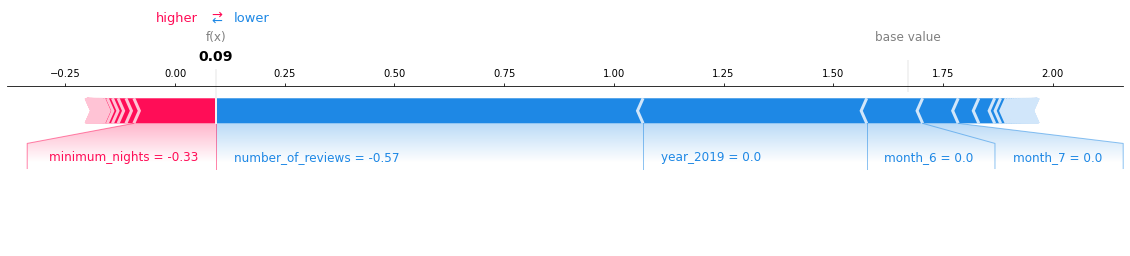

In [46]:
# Round shapley values for ease of visualization
X_test_enc = X_test_enc.round(2)

shap.initjs()
shap.force_plot(
    lgbm_explainer.expected_value,
    test_lgbm_shap_values[3],
    X_test_enc.iloc[3, :], 
    matplotlib=True,
)

In [47]:
true_3 = y_test.iloc[3]
true_3

0.02

_From the above graphic and calculations we can see that the base value (average value) for the target is 1.33. Our true target value for the test sample number 3 is 0.02 and our model has predicted a value of 0.06. The major negative forces (feature values) driving this prediction towards 0.06 are `number_of_reviews`, `year_2019`, `month_6`, and `month_7`. The major positive force (feature value) pushing the prediction to its current value is `minimum_nights`._

<br><br>

## 13. Summary of results 
<hr>

Imagine that you want to present the summary of these results to your boss and co-workers. 

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

In [48]:
re_col = [
    "Dummy Regressor",
    "Ridge",
    "Tuned Ridge",
    "SVR",
    "Tuned SVR",
    "Random Forest",
    "Tuned RF",
    "LGBM Regressor",
    "Tuned LGBM",
]
summary = pd.DataFrame(results).reindex(columns=re_col)
summary

,Dummy Regressor,Ridge,Tuned Ridge,SVR,Tuned SVR,Random Forest,Tuned RF,LGBM Regressor,Tuned LGBM
fit_time,0.171 (+/- 0.010),0.209 (+/- 0.011),0.184 (+/- 0.007),7.625 (+/- 0.294),30.532 (+/- 1.257),59.708 (+/- 2.582),16.917 (+/- 0.332),0.448 (+/- 0.059),0.578 (+/- 0.009)
score_time,0.041 (+/- 0.013),0.051 (+/- 0.017),0.043 (+/- 0.002),1.424 (+/- 0.101),1.623 (+/- 0.139),0.100 (+/- 0.009),0.076 (+/- 0.005),0.125 (+/- 0.010),0.130 (+/- 0.006)
test_score,-1.666 (+/- 0.072),-1.132 (+/- 0.033),-1.123 (+/- 0.036),-1.102 (+/- 0.056),-1.081 (+/- 0.045),-1.002 (+/- 0.058),-1.004 (+/- 0.053),-0.987 (+/- 0.048),-0.987 (+/- 0.044)
train_score,-1.666 (+/- 0.018),-1.081 (+/- 0.008),-1.087 (+/- 0.009),-0.976 (+/- 0.013),-0.534 (+/- 0.019),-0.373 (+/- 0.008),-0.772 (+/- 0.009),-0.770 (+/- 0.007),-0.849 (+/- 0.010)


Since I was dealing with a regression problem, I used a Dummy Regressor as my baseline, and selected Root Mean Square Error (RMSE) as my scoring metric. I got a RMSE baseline of 1.66. I then tried two simple models of Linear regression (Ridge) and Support Vector Machine (SVR) and tried tuning the models to see if I could improve the score. Although SVR was giving me a better score than Ridge, it was a slow model. Therefore, I selected two tree-based models of RandomForeset Regressor and LGBM Regressor to see if I could improve speed and also performance. Although they both gave me better scores, Random Forest was even slower than SVR, and was suffering from overfitting. LGBM was not only giving me a better score, but also much faster than the other two. As my chosen final model, I did hyperparameter tuning and feature selection on LGBM Regressor which did not change my mean CV RMSE a lot.

<br><br><br>

## 14. Other Ideas - Future Improvements

This data set was already large and in order to compensate for lack of resources on my computer, I allocated a higher percentage of the original data to test set. I could try giving a larger percentage to the train data on a stronger computer to see if my scores would improve. Although I created 3 extra features which proved to be useful, I could have allocated more time to feature engineering. Also, I used RFECV which was very resource incentive taking away the opportunity (time) to try out ensemble models. Instead, I could have used a faster method like SelectFromModel using lasso to see if I could do some faster feature selection using L1 regularization. With this I could even try feature selection on more interpretable models like Ridge to see if I could improve the performance. Last but not the least, I did not try any ensemble models which could be a future addition to the project._  
_As a proof of concept for time saving, below I have added SelectFromModel with Lasso as a feature selection step. This only took only a fraction of time (less than 1s average fit time versus 416s average fit time) when compared to the RFECV feature selection! Also, using Lasso we see an over 1 percent improvement in RMSE while RFECV inscrased RMSE._

In [49]:
lgbm_lasso_pipe = make_pipeline(
    preprocessor,
    SelectFromModel(Lasso(alpha=0.001, max_iter=100000)),
    LGBMRegressor(
            random_state=2021,
            verbose=0,
            force_col_wise=True,
        )
)

In [50]:
summary["LGBM Feature Selection"] = mean_std_cross_val_scores(lgbm_lasso_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(summary)

,Dummy Regressor,Ridge,Tuned Ridge,SVR,Tuned SVR,Random Forest,Tuned RF,LGBM Regressor,Tuned LGBM,LGBM Feature Selection
fit_time,0.171 (+/- 0.010),0.209 (+/- 0.011),0.184 (+/- 0.007),7.625 (+/- 0.294),30.532 (+/- 1.257),59.708 (+/- 2.582),16.917 (+/- 0.332),0.448 (+/- 0.059),0.578 (+/- 0.009),1.282 (+/- 0.173)
score_time,0.041 (+/- 0.013),0.051 (+/- 0.017),0.043 (+/- 0.002),1.424 (+/- 0.101),1.623 (+/- 0.139),0.100 (+/- 0.009),0.076 (+/- 0.005),0.125 (+/- 0.010),0.130 (+/- 0.006),0.127 (+/- 0.015)
test_score,-1.666 (+/- 0.072),-1.132 (+/- 0.033),-1.123 (+/- 0.036),-1.102 (+/- 0.056),-1.081 (+/- 0.045),-1.002 (+/- 0.058),-1.004 (+/- 0.053),-0.987 (+/- 0.048),-0.987 (+/- 0.044),-0.987 (+/- 0.045)
train_score,-1.666 (+/- 0.018),-1.081 (+/- 0.008),-1.087 (+/- 0.009),-0.976 (+/- 0.013),-0.534 (+/- 0.019),-0.373 (+/- 0.008),-0.772 (+/- 0.009),-0.770 (+/- 0.007),-0.849 (+/- 0.010),-0.772 (+/- 0.009)


<br><br>

<br><br>